In [1]:
import numpy as np
import pandas as pd
import matplotlib
print(matplotlib.__version__)
matplotlib.use('PDF')
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.lines as mlines
from glob import glob
from collections import Counter
#import ns
import history_cmc as hic
import math
import scipy
#from scipy.interpolate import interp1d
#from scipy import stats
import matplotlib.cm as cm
import matplotlib as mpl
import random
from random import shuffle
import gzip
import sys
import astropy
from astropy import units
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
print('done')

#import gw_ecc_calc as gwcalc
#import unit_convert as uc
#import merger_rate_calculator as mr
#import ns_tidalcapture as tc
import conversions
import dynamics as dyn
print('done')

%matplotlib inline

matplotlib.rcParams.update({'font.size': 24})

sys.path.insert(1, '/fs/lustre/cita/claireshiye/cmctoolkit')
import cmctoolkit as cmct
      
twopi=2.*np.pi
yearsc=3.1557*10**7
Kconst=9.87*10**-48 ##yr/G^2
Gconst=6.674*10**-8 ##cm3*g-1*s-2
Gconst_sun = 4.30091*10**-3 ##pc*M_sun**-1*(km/s)^2
clight=3*10**10 ##cm/s
Msun=2*10**33 ##gram
AU=1.496*10**13  ##cm
AU_Rsun=214.93946938362 ##AU to R_sun
PC=3.086*10**18  ##cm
PC_Rsun = 44334448.0068964 ##pc to R_sun

3.5.2
done
done


/fs/lustre/cita/claireshiye/CMC-COSMIC/CMC/M15/N1.8e6rv0.8z0.0002rg11/
14 14 14
12498.6
/fs/lustre/cita/claireshiye/CMC-COSMIC/CMC/M15/N2e6rv0.7z0.002rg11/
8 7 7
13288.8


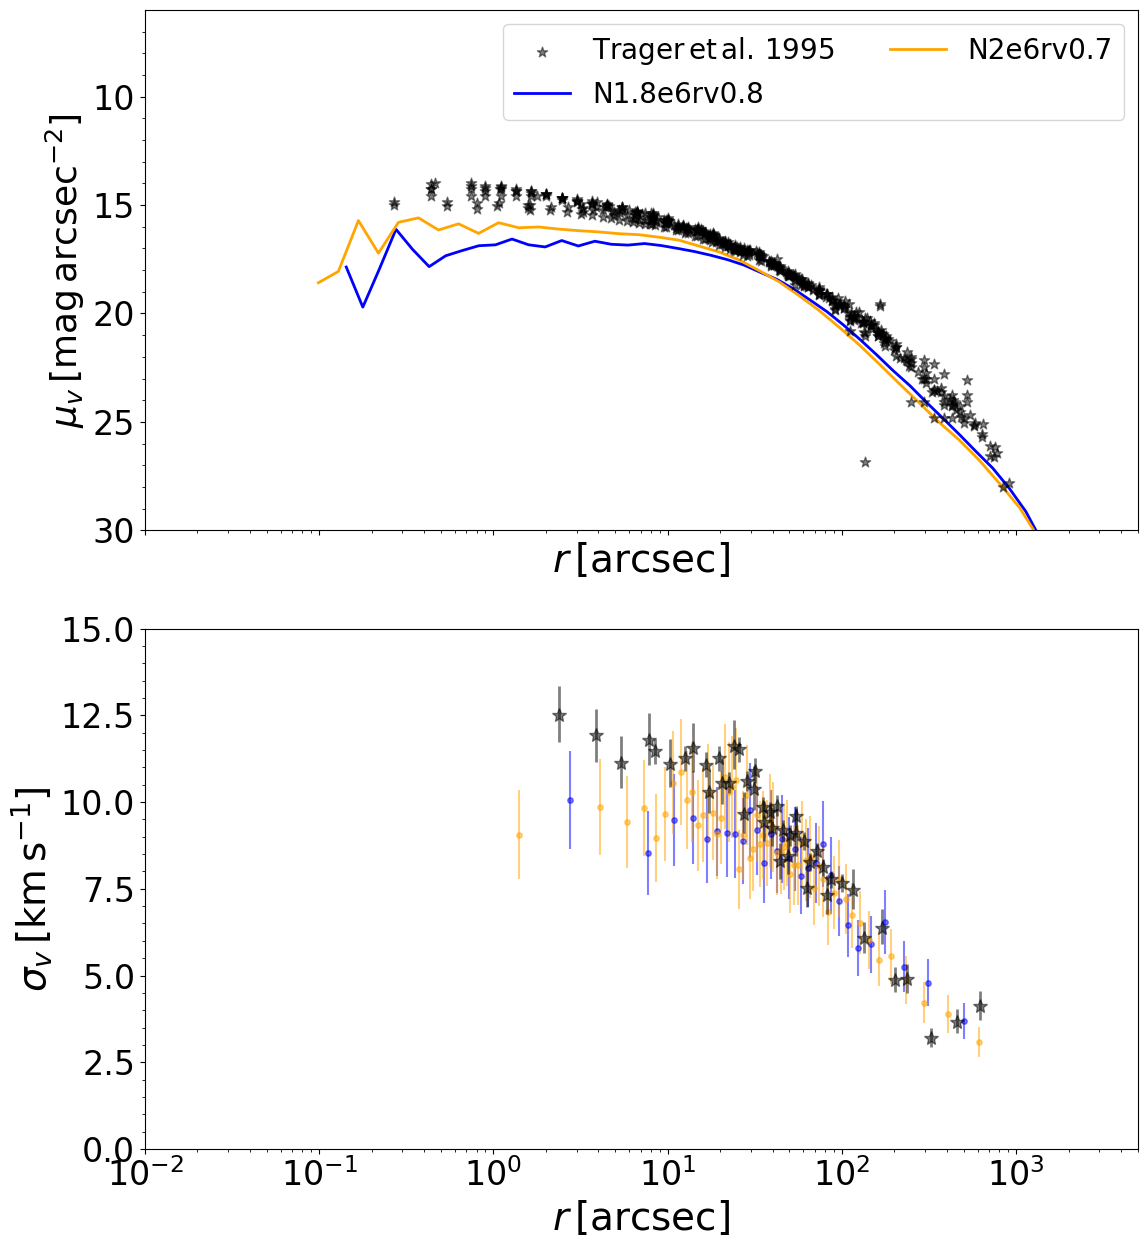

In [2]:

path = ['/fs/lustre/cita/claireshiye/CMC-COSMIC/CMC/M15/N1.8e6rv0.8z0.0002rg11/', 
        '/fs/lustre/cita/claireshiye/CMC-COSMIC/CMC/M15/N2e6rv0.7z0.002rg11/']
prefix = ['initial18', 'initial21']
##First Check

##Surface brightness and velocity dispersion profiles
###Observations###
R_sun_obs=10.709
ngcno='7078'

ft = open('makeSBP/trager.dat','r')
linest = ft.readlines()


fv = open('makeSBP/vel_dispersion_profiles_100423.dat','r')
linesv = fv.readlines()

flag = 0
#### find observed SBP from trager file
arcsec_t = []
SB_t = []
for k in range(len(linest)):
    linet = linest[k]
    linet = linet.split('\n')
    linet = linet[0]
    linet = linet.split('\t')
    cluster_tregar = linet[1]
    if cluster_tregar == 'ngc'+ngcno:
        arcsec_t.append(float(linet[2]))
        SB_t.append(float(linet[3]))
        flag = 1
arcsec_t = np.array(arcsec_t[:])
SB_t = np.array(SB_t[:])
if flag == 0:
        print('Trager doesnt have the SBP or sigma v profile')
        sys.exit()

flag = 0
#### find observed sigma_v profile
datav = np.genfromtxt('makeSBP/vel_dispersion_profiles_100423.dat')
R_obs = [] # in arcsec
sigma_obs = []
sigma_err_obs_up = []
sigma_err_obs_down = []
for k in range(len(linesv)):
    linev = linesv[k]
    linev = linev.split('\n')
    linev = linev[0]
    linev = linev.split(' ')
    cluster_sigma = linev[0]
    if cluster_sigma == 'NGC'+ngcno:
        R_obs.append(datav[k,1])
        sigma_obs.append(datav[k,2])
        sigma_err_obs_up.append(datav[k,3])
        sigma_err_obs_down.append(datav[k,4])
        flag = 1
R_obs = np.array(R_obs[:])
sigma_obs = np.array(sigma_obs[:])
sigma_err_obs_up = np.array(sigma_err_obs_up[:])
sigma_err_obs_down = np.array(sigma_err_obs_down[:])
############
if flag == 0:
        print('No observed sigmav profile')
        sys.exit()
        

fig, ax=plt.subplots(2, 1, sharex=True,  figsize=(12,13))
#ax[0].set_title(r'$\rm{NGC}\ $'+ngcno, fontsize=20)
ax[0].scatter(10**arcsec_t[:], SB_t[:], facecolor='k', marker = '*', 
              alpha=0.5, s=60, label=r'$\rm{Trager\,et\,al.\,1995}$', zorder=3)
ax[1].errorbar(R_obs,sigma_obs,yerr=[sigma_err_obs_down,sigma_err_obs_up], fmt='*', 
               markersize = 10, alpha=0.5, c='k', lw=2.0, zorder=3)
ax[1].scatter([10000,10000], [-5,-5], c='k', marker = '*', alpha=0.5, s=60)

###Models###
#cs=['cyan','b','g','purple','orange', 'r']
cs=['b','orange']
lbs = ['N1.8e6rv0.8', 'N2e6rv0.7']
for xx in range(len(path)): #len(path)
    print(path[xx])
    snap2D = np.sort(glob(path[xx]+prefix[xx]+'.snap*.2Dproj.dat.gz'))
    snap2D_L12 = np.sort(glob(path[xx]+prefix[xx]+'.snap*.2D_SBPLcut12_NCUT-1.dat'))
    snap_vel700 = np.sort(glob(path[xx]+prefix[xx]+'.snap*.vel_dispersion_vr_pm_100_0.8.dat'))
    print(len(snap2D), len(snap2D_L12), len(snap_vel700))
 
    for ii in range(0, len(snap2D_L12)):
        with open(snap2D_L12[ii], 'r') as f2D:
            first_line=f2D.readline()

        t_gyr = float(first_line.strip().split('=')[-1])
        if t_gyr>=10900.:
            print(t_gyr)
            data5 = np.genfromtxt(snap2D_L12[ii])
            arcsec = conversions.pc_to_arcsec(data5[:,1],R_sun_obs)
            SB = conversions.SB_converter(data5[:,3])
            SBerr = data5[:,6]/data5[:,5]*SB
            
            arcsec_cut = []
            SB_cut = []
            SBerr_cut = []
            for k in range(len(SB)):
                if arcsec[k] < 10 and SB[k] > 20:
                    Nothing = 0
                else:
                    arcsec_cut.append(arcsec[k])
                    SB_cut.append(SB[k])
                    #SBerr_cut.append(SBerr[k])
        
            datavel = np.genfromtxt(snap_vel700[ii])
            R_model = conversions.pc_to_arcsec(datavel[:,0],R_sun_obs)
            sigma_model = datavel[:,1]
            sigma_err_model = datavel[:,2]
        
            ax[0].plot(arcsec_cut, SB_cut, lw=2, label=lbs[xx], color=cs[xx])
            ax[0].plot([10000,10000],[-5,-5], lw=2)
            ax[1].scatter(R_model[::3], sigma_model[::3],s=15,zorder=2,alpha=0.5, color=cs[xx])
            ax[1].errorbar(R_model[::3],sigma_model[::3],yerr=2*sigma_err_model[::3], fmt='o',
                           markersize=0.01,zorder=1,alpha=0.5, color=cs[xx])

            break

ax[0].yaxis.set_minor_locator(AutoMinorLocator())
ax[0].set_ylim(30,6)
ax[0].set_xscale('log')
ax[0].set_xlim(0.01,5000)
ax[0].set_ylabel(r'$\mu_v\,[\rm{mag\,arcsec^{-2}}]$',fontsize=26)
ax[0].set_xlabel(r'$r\,[\rm{arcsec}]$',fontsize=28)
ax[0].legend(loc='best',scatterpoints=1, ncol=2, prop={'size': 20})

ax[1].yaxis.set_minor_locator(AutoMinorLocator())
ax[1].set_xscale('log')
ax[1].set_xlim(0.01,5000)
ax[1].set_ylim(0, 15)
ax[1].set_xlabel(r'$r\,[\rm{arcsec}]$',fontsize=28)
ax[1].set_ylabel(r'$\sigma_v\,[\rm{km\,s^{-1}}]$',fontsize=28)
#ax[1].legend(loc=3,scatterpoints=1, ncol=2, prop={'size': 24})

plt.subplots_adjust(hspace=0.05)
fig.tight_layout()